#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
%matplotlib notebook
#%matplotlib inline


In [2]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [205]:
%run chx_generic_functions.py
%run XPCS_SAXS.py
#%run Two_Time_Correlation_Function.py
#%run speckle.py

In [4]:
plt.rcParams.update({'figure.max_open_warning': 0})

# Startup Setting

## Detector

In [5]:
#detectors = ['eiger4m_single_image', 'eiger1m_single_image', 'eiger4m_image', 'eiger1m_image']
detector = 'eiger4m_single_image'  #for after 2015-12 data
detector = 'eiger_4M_cam_img_image_lightfield'  #for before 2015-12 data

In [6]:
path = '/home/yuzhang/Analysis/2016_1/Results/'

dt =datetime.now()
CurTime = '%s%02d%02d-%02d%02d' % (dt.year, dt.month, dt.day,dt.hour,dt.minute)


mask_name =  'ee6975a1-9161_mask.npy'



### Get the image series and metadata from the uid

In [7]:
uid='ee6975a1-9161'   #1% wt PEG
sn = 'SiO2_Colloidal'


In [8]:
if not os.path.exists(path+'%s'%(sn)):
    os.mkdir( path + sn )
    path = path + sn + '/'
print ("The analysis results will be saved in : %s"%path)    

The analysis results will be saved in : /home/yuzhang/Analysis/2016_1/Results/


In [9]:
get_sid_filenames(db[uid])

(1224,
 'ee6975a1-9161-4315-9929-4db995a91b5c',
 ['/XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138'])

In [10]:
imgs = load_data( uid, detector  )
md = imgs.md

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5


In [11]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [12]:
sampling = 100

In [13]:
uid = uid[:8] +'--%s_'%sn
print (uid)

ee6975a1--SiO2_Colloidal_


## Overwrite some metadata due to wrong input

In [14]:
md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [15]:
dpix =   0.075        #in eiger 4M, mm
Ldet = md['detector_distance'] *1000     #4840 in mm
lambda_  = md['incident_wavelength']  #1.4250998
timeperframe=md['frame_time']
#center = md['beam_center_x'], md['beam_center_y'] 

center = [ 846,1830]  # center of the speckle pattern


center=[center[1], center[0]]
print (center)

[1830, 846]


In [16]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [17]:
setup_pargs

{'Ldet': 4840.0001525878906,
 'center': [1830, 846],
 'dpix': 0.075,
 'lambda_': 1.3776,
 'timeperframe': 0.0049999999,
 'uid': 'ee6975a1--SiO2_Colloidal_'}

## Load Mask 

In [147]:
mask = load_mask( path, mask_name, plot_ =  False )

## Apply Mask to time-series

In [19]:
imgsa = apply_mask( imgs, mask )

## Check shutter open frame and get good time series

In [21]:
good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )

The first frame with open shutter is : 0


In [22]:
good_series = apply_mask( imgs[good_start:], mask )
Nimg = len(good_series)

## Get intensity average image

In [148]:
avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


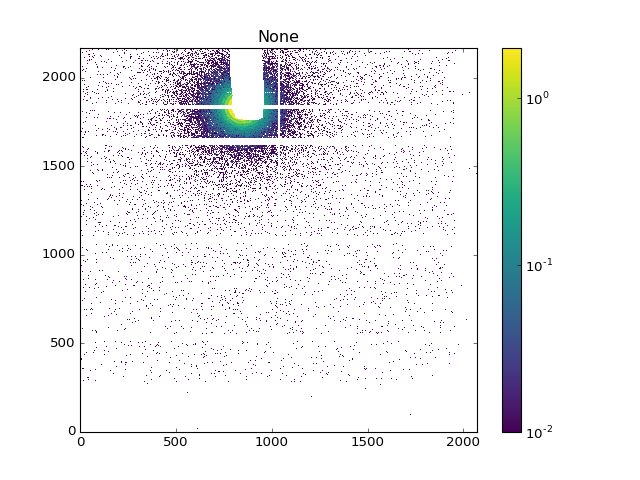

In [149]:
show_img( avg_img,  vmin=.01, vmax=2, logs=True )

<IPython.core.display.Javascript object>


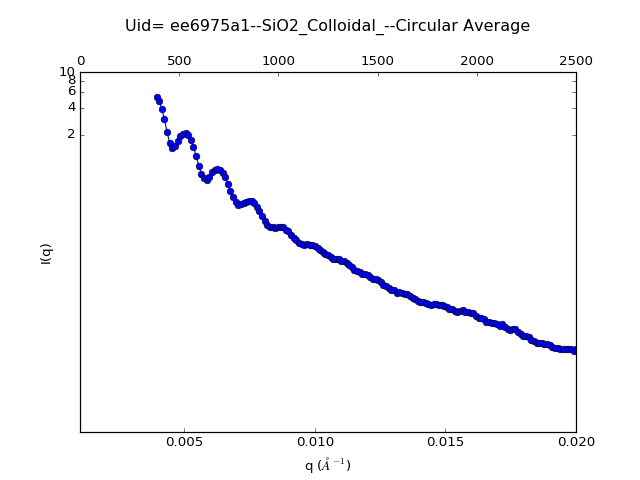

In [187]:
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                                 plot_ = True, plot_qinpixel=False, xlim=[0.001,.02], ylim = [0.001, 10])

## Spatial Correlation

In [43]:
%run Spatial_Correlation_Function.py

In [121]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=58, outer_radius = 120,
                                     width = 10, num_rings = 6, pargs=setup_pargs   )

In [218]:
ang_mask, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= -180, 
                     outer_angle = 180, width = 80,  num_angles =4, center = center    )

In [219]:
#show_ROI_on_image( avg_img, ang_mask, center, label_on = True, rwidth=200, alpha=.6)

In [220]:
 seg_mask,  rcen, acen = get_ring_anglar_mask( ring_mask, ang_mask, q_ring_center, ang_center)  #for angle involved

In [221]:
#mask_ = ring_mask
mask_ = seg_mask

<IPython.core.display.Javascript object>


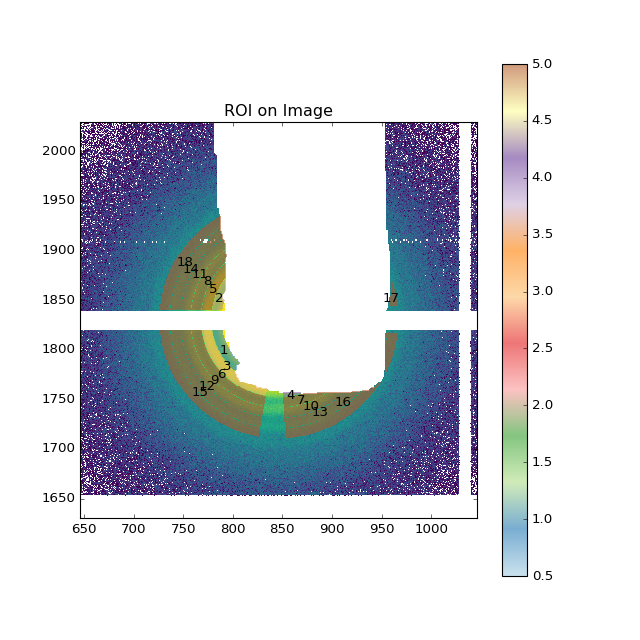

In [222]:
show_ROI_on_image( avg_img, mask_, center, label_on = True, rwidth=200, alpha=.6)

In [224]:


sub_mask = np.zeros_like( mask_ )
sub_mask[ np.where( mask_ ==3) ] = 1

In [225]:
#show_img( sub_mask)

In [231]:
img1 = imgsa[70]
img2 =  imgsa[70]
#imgc = cross_corr_subregion( img1,img2, mask_seg= sub_mask)  
imgc = cross_corr_subregion( img1,img2, mask_seg= sub_mask, center =center, q_pixel=qp, sq=iq)

In [232]:
#show_img( imgc, aspect = 1, image_name = 'Spactial_Cor')
#print (imgc.shape)

2.67540113585 [  0.30285271  10.00030834  10.00023437   0.05285181   0.77091898
   0.84564366   0.25197181]
Area =  1.18299522967


<IPython.core.display.Javascript object>


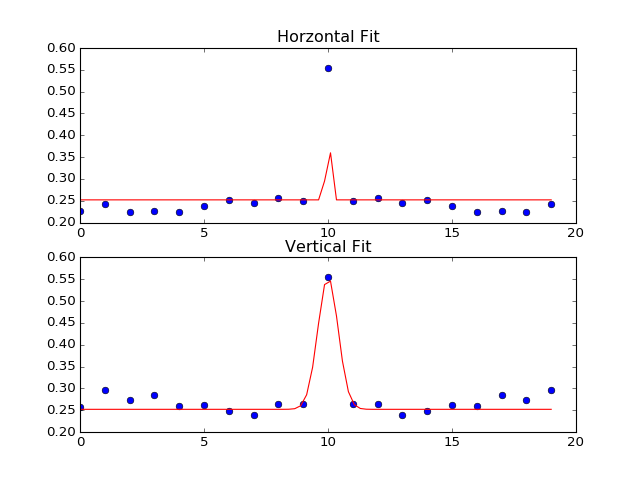

<IPython.core.display.Javascript object>


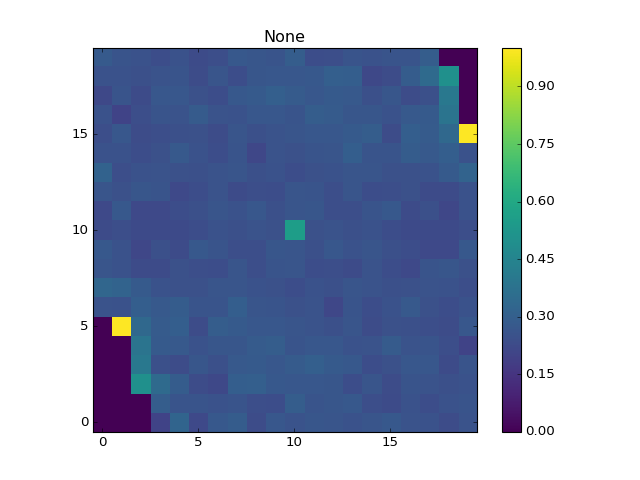

In [233]:
#imgc_center_part,max_cx, max_cy = get_cross_plot( imgc, imgc_width = None,plot_=True,  cx=None, cy = None)
dw = 10
imgc_center_part,max_cx, max_cy = get_cross_plot( imgc, imgc_width = dw,plot_= False,  cx= dw, cy = dw)
fit_two_Gaussian( imgc_center_part,  max_cx, max_cy, initial_guess = (1, dw , dw , 1, 1, 0, 0), plot_=True  )
                        #initial_guess =  amplitude, xo, yo, sigma_x, sigma_y, theta, offset
show_img( imgc_center_part, aspect =1  )

# The End!